In [25]:
#Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


In [5]:
#Load the dataset
df = pd.read_csv("data/Sample_Superstore.csv", encoding="latin-1")

# Exploratory Data Analysis

In this section, we explore the dataset to understand its structure, quality, and main characteristics before performing deeper analysis.

In [9]:
#Dataset structure and info
df.shape

(9994, 21)

In [14]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   str    
 2   Order Date     9994 non-null   str    
 3   Ship Date      9994 non-null   str    
 4   Ship Mode      9994 non-null   str    
 5   Customer ID    9994 non-null   str    
 6   Customer Name  9994 non-null   str    
 7   Segment        9994 non-null   str    
 8   Country        9994 non-null   str    
 9   City           9994 non-null   str    
 10  State          9994 non-null   str    
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   str    
 13  Product ID     9994 non-null   str    
 14  Category       9994 non-null   str    
 15  Sub-Category   9994 non-null   str    
 16  Product Name   9994 non-null   str    
 17  Sales          9994 non-null   float64
 18  Quantity       9994

In [16]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [32]:
df["Country"].value_counts()

Country
United States    9994
Name: count, dtype: int64

In [33]:
df["Segment"].value_counts()

Segment
Consumer       5191
Corporate      3020
Home Office    1783
Name: count, dtype: int64

In [35]:
df["Ship Mode"].value_counts()

Ship Mode
Standard Class    5968
Second Class      1945
First Class       1538
Same Day           543
Name: count, dtype: int64

In [17]:
# Data type adjustments
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])
df["Postal Code"] = df["Postal Code"].astype(str)


In [21]:
# Descriptive statistics
numeric_cols = ["Sales", "Quantity", "Discount", "Profit"]
df[numeric_cols].describe()

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


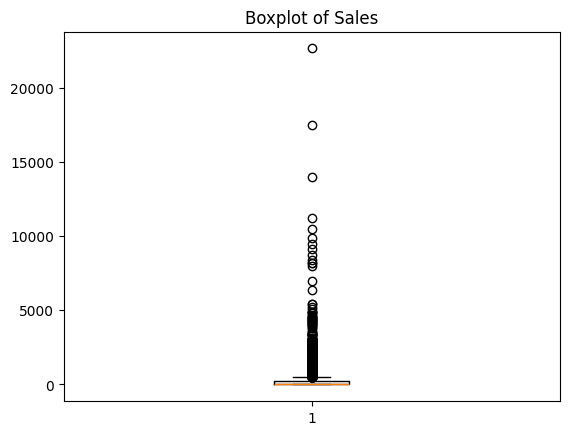

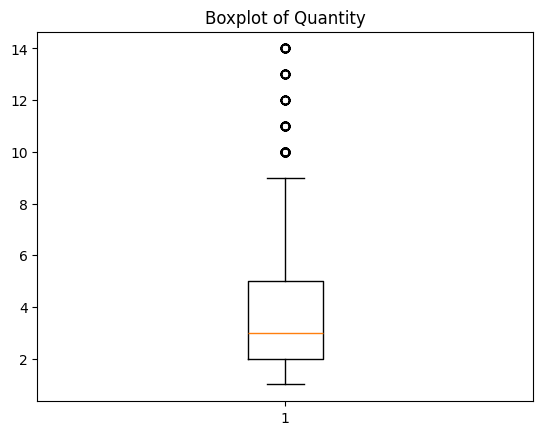

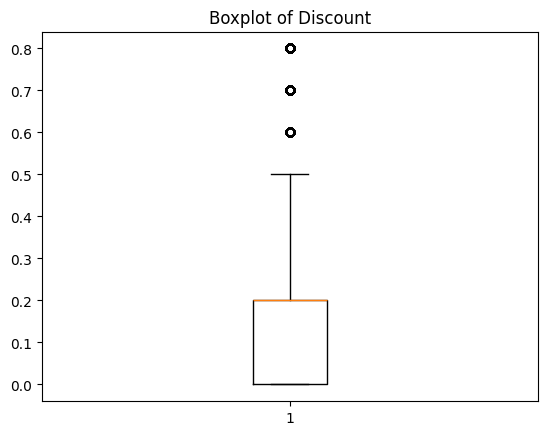

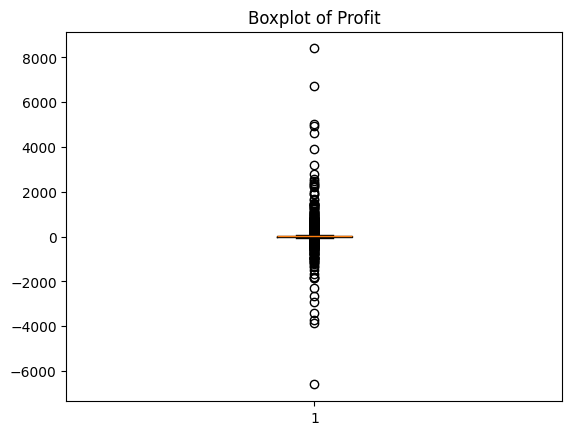

In [23]:
# # Visual inspection of numerical variables to detect potential outliers
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

-Sales: Most sales are relatively small, while a few large orders account for very high sales values. This indicates a strong right-skewed distribution, which is typical in retail datasets.

-Quantity: Most orders include between 1 and 5 units. Higher quantities appear occasionally and likely represent bulk purchases rather than data issues.

-Discount: Discounts are mostly applied at fixed levels, especially 0% and 20%. This suggests the use of standard discount rules, while higher discounts seem to be reserved for specific promotional cases.

-Profit: Profit per transaction is generally low and centered close to zero. While many sales are profitable, there are also several cases with significant losses, which may indicate margin pressure in certain situations.


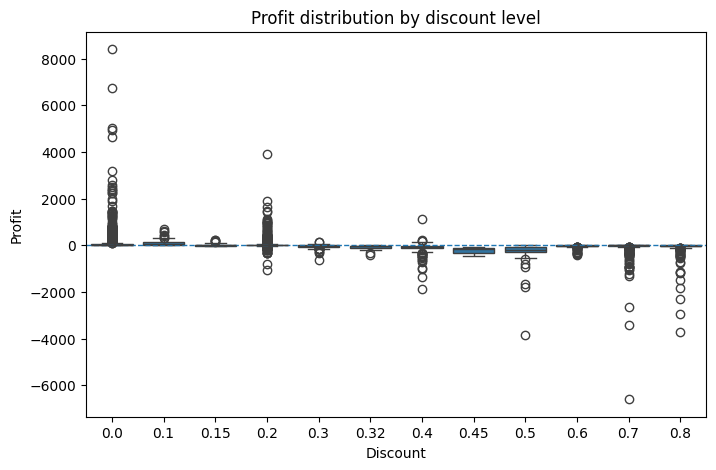

In [26]:
#Analyze profit by discount
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Discount", y="Profit")

plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Profit distribution by discount level")
plt.xlabel("Discount")
plt.ylabel("Profit")

plt.show()

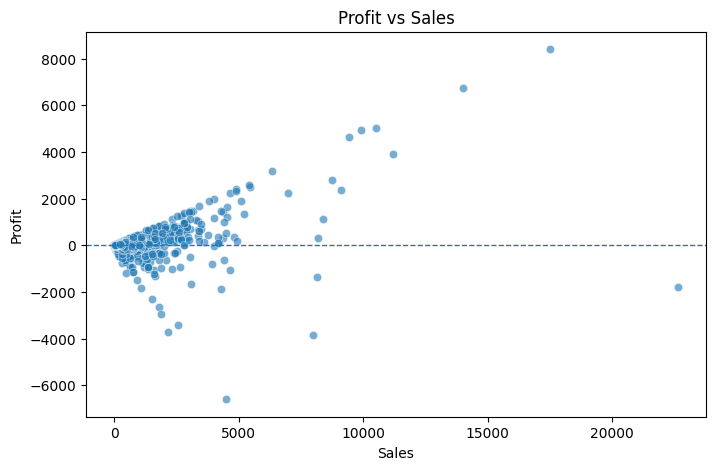

In [27]:
#Analyze profit vs sales
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Sales", y="Profit", alpha=0.6)

plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Profit vs Sales")
plt.xlabel("Sales")
plt.ylabel("Profit")

plt.show()

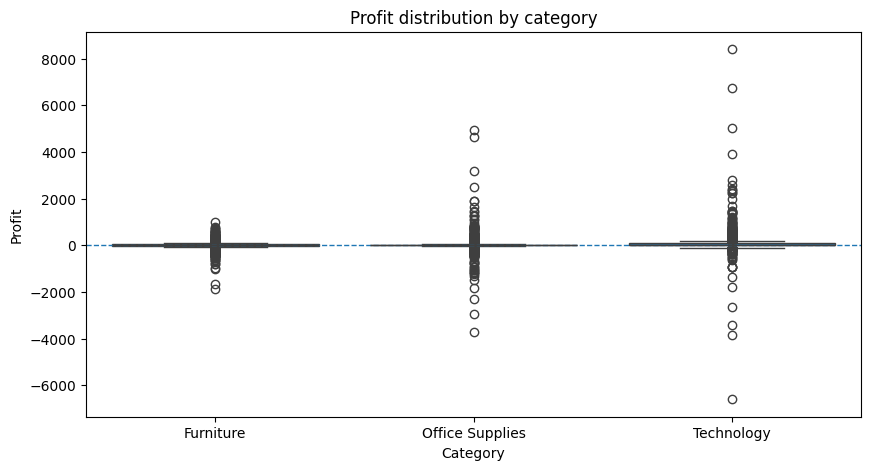

In [28]:
#Analyze Profit by category
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="Category", y="Profit")

plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Profit distribution by category")
plt.xlabel("Category")
plt.ylabel("Profit")

plt.show()

-Discount clearly hurts profitability: Orders without discounts tend to be profitable, but as discounts increase, profits quickly turn negative. This stands out as the main takeaway from the analysis.

-High sales don’t necessarily mean high profit: Some large sales still end up losing money, which suggests that discounts and other costs are eating into margins.

-Categories behave differently: Technology is much more volatile, with both strong gains and heavy losses, while Furniture remains fairly stable, usually staying close to break-even.

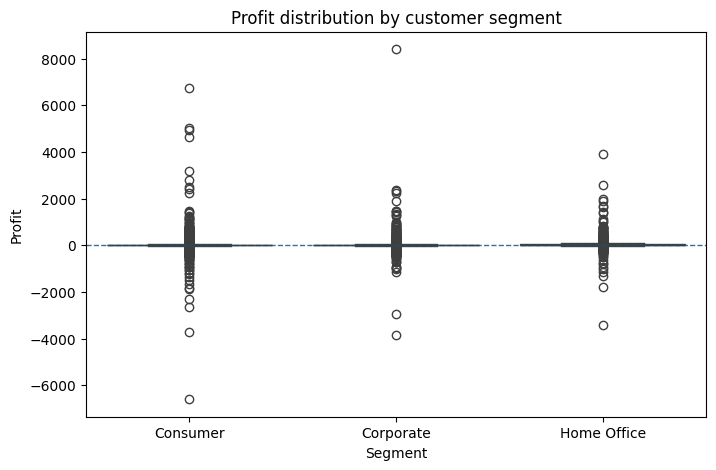

In [30]:
#Analyze profit by customer segment
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Segment", y="Profit")

plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Profit distribution by customer segment")
plt.xlabel("Segment")
plt.ylabel("Profit")

plt.show()

All transactions belong to the United States, so the geographic analysis focuses on regional differences rather than country-level comparisons.

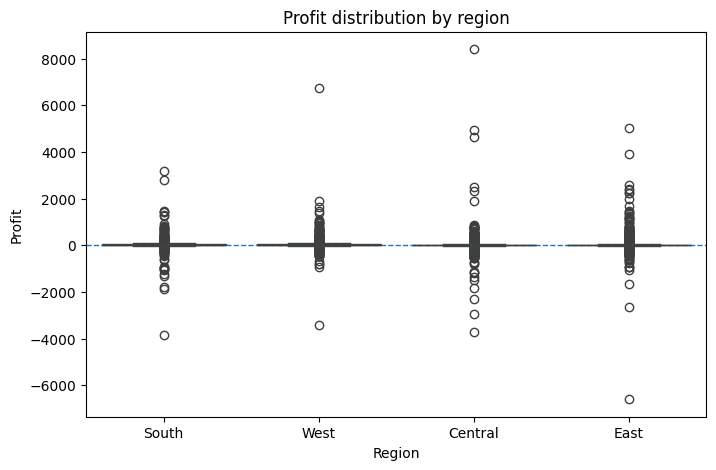

In [31]:
#Analyze profit by region
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Region", y="Profit")

plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Profit distribution by region")
plt.xlabel("Region")
plt.ylabel("Profit")

plt.show()

The analysis shows that low profitability is not driven by geographic factors. All regions (South, West, Central, and East) display a similar pattern, with profits generally close to zero and occasional losses. The most evident driver of margin erosion is discounting: transactions without discounts tend to be profitable, but as discount levels increase, profit quickly turns negative.
There are, however, clear differences across customer segments. Home Office generates a higher average profit (around $35) compared to Consumer (around $26), suggesting that unit margins or discount policies may vary by segment. A natural next step is to quantify the exact impact of discounts, shipping costs, and product margins on overall profit erosion.

In [38]:
   df.to_csv('sample_superstore_processed.csv', index=False)